In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/home11/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home12/khou/scTRS_results/'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=147.7s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/home12/khou/.local/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/home12/khou/.local/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load gene annotation

In [5]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [6]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Exploration

In [7]:
trait_list = ['PASS_MDD_Wray2018', 'PASS_ADHD_Demontis2018', 'PASS_SCZvsBD_Ruderfer2018',
              'PASS_Coronary_Artery_Disease', 'PASS_CardioembolicStroke_Malik2018', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_IBD_deLange2017', 'PASS_Type_1_Diabetes']

tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(tissue_list), len(tc_list)))

# facs data: n_tissue=23 n_tissue_celltype=207


In [ ]:
md.score_cell_kangcheng_072920

In [9]:
# Assign TRS
for trait in trait_list:
    
    # Find FDR<0.1 genes 
    temp_v = np.absolute(df_geneannot[trait].values)
    temp_v = 1 - sp.stats.norm.cdf(temp_v)
    temp_v = multipletests(temp_v, method='fdr_bh')[1]
    gene_list = list(df_geneannot.index[temp_v<0.1])
    print('# trait=%-40s FDR<0.1 genes=%d'%(trait, len(gene_list)))
    
    # TRS score trs_
    md.score_cell_kangcheng_072920(data_facs_ct, gene_list, suffix='raw_%s'%trait, flag_correct_background=False, flag_specific_expressed=False)
    # background-corrected TRS score: trs_bc_ 
    md.score_cell_kangcheng_072920(data_facs_ct, gene_list, suffix='bc_%s'%trait, flag_correct_background=True, flag_specific_expressed=False)
    # both background-corrected and specific expressed: se_bc_%s
    md.score_cell_kangcheng_072920(data_facs_ct, gene_list, suffix='se_bc_%s'%trait, flag_correct_background=True, flag_specific_expressed=True)

# trait=PASS_MDD_Wray2018                        FDR<0.1 genes=128
# score_cell: 128/117 gene_list genes also in adata
# score_cell: suffix=raw_PASS_MDD_Wray2018, flag_correct_background=False, flag_specific_expressed=False
# score_cell: 128/117 gene_list genes also in adata
# score_cell: suffix=bc_PASS_MDD_Wray2018, flag_correct_background=True, flag_specific_expressed=False
# score_cell: 128/117 gene_list genes also in adata
# score_cell: suffix=se_bc_PASS_MDD_Wray2018, flag_correct_background=True, flag_specific_expressed=True
# trait=PASS_ADHD_Demontis2018                   FDR<0.1 genes=236
# score_cell: 236/214 gene_list genes also in adata
# score_cell: suffix=raw_PASS_ADHD_Demontis2018, flag_correct_background=False, flag_specific_expressed=False
# score_cell: 236/214 gene_list genes also in adata
# score_cell: suffix=bc_PASS_ADHD_Demontis2018, flag_correct_background=True, flag_specific_expressed=False
# score_cell: 236/214 gene_list genes also in adata
# score_cell: suffix=se

In [10]:
# Find number of associated cells for each tissue/tissue_celltype
dic_assoc = dict()
for trs_type in ['raw', 'bc', 'se_bc']:
    dic_assoc[f'{trs_type}.tissue'] = pd.DataFrame(index=tissue_list, columns=trait_list, data=0)
    dic_assoc[f'{trs_type}.tc'] = pd.DataFrame(index=tc_list, columns=trait_list, data=0)

df_obs = data_facs_ct.obs.copy()

for trait in trait_list:
    
    print('# %s'%trait)
    for trs_type in ['raw', 'bc', 'se_bc']:
        # For plotting change the FDR threshold for SE_BC to 0.01
        fdr_threshold = 0.01 if trs_type == 'se_bc' else 0.2
        
        # stratify by tissues
        temp_df = df_obs.loc[df_obs[f'trs_{trs_type}_{trait}_bhp'] < fdr_threshold].copy()
        temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
        temp_df = temp_df.loc[~temp_df['cell'].isna()]
        dic_assoc[f'{trs_type}.tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
        
        # stratify by tissue celltypes
        temp_df = df_obs.loc[df_obs[f'trs_{trs_type}_{trait}_bhp'] < fdr_threshold].copy()
        temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
        temp_df = temp_df.loc[~temp_df['cell'].isna()]
        dic_assoc[f'{trs_type}.tc'].loc[temp_df.index, trait] = temp_df['cell'].values  

# PASS_MDD_Wray2018
# PASS_ADHD_Demontis2018
# PASS_SCZvsBD_Ruderfer2018
# PASS_Coronary_Artery_Disease
# PASS_CardioembolicStroke_Malik2018
# PASS_LDL
# PASS_Rheumatoid_Arthritis
# PASS_IBD_deLange2017
# PASS_Type_1_Diabetes


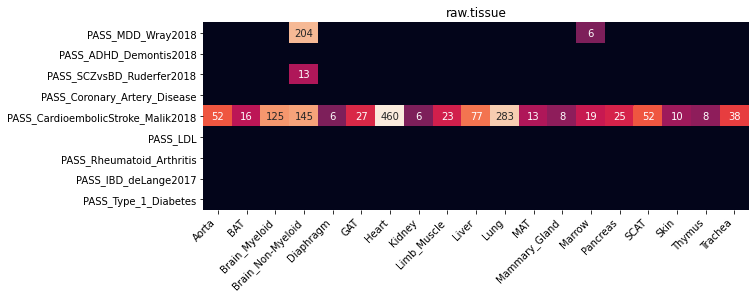

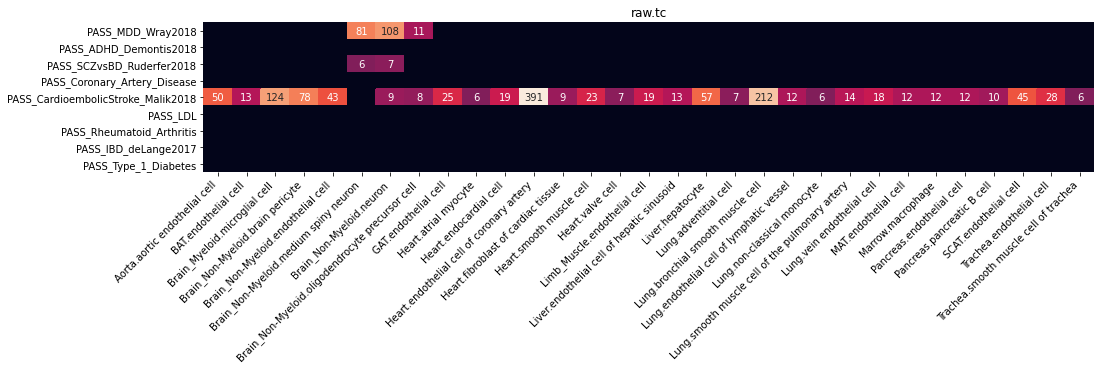

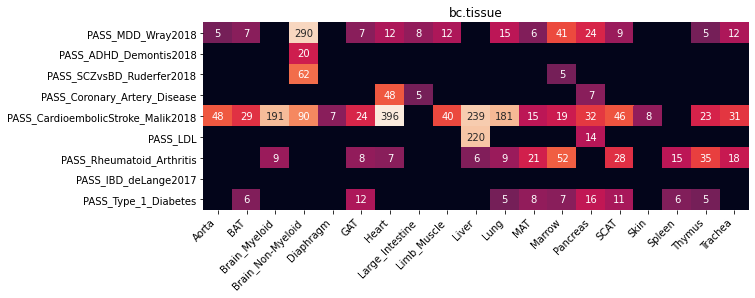

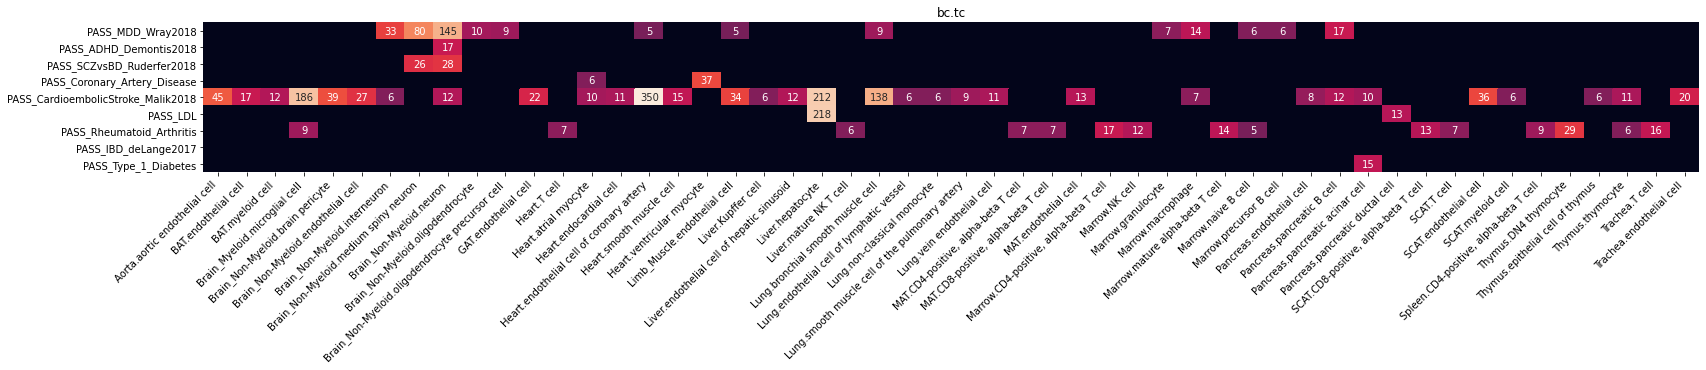

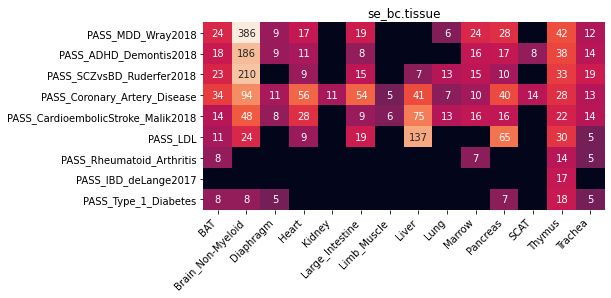

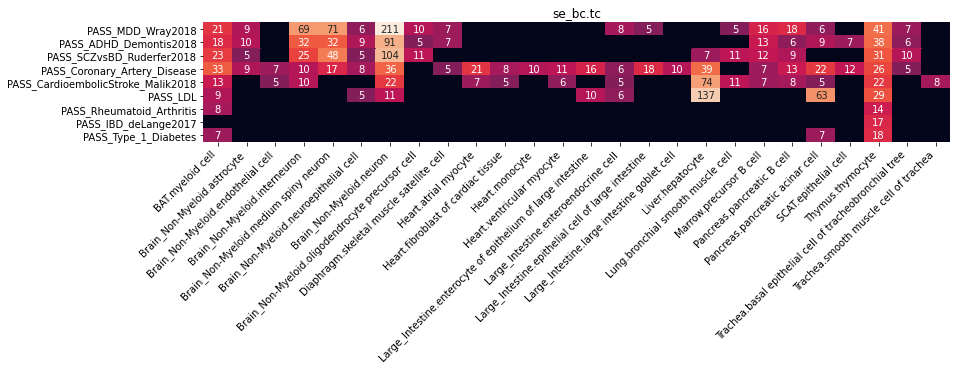

In [11]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    
for term in dic_assoc.keys():

    df_plot = dic_assoc[term].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>5]
    df_plot = df_plot.T
    df_plot[df_plot<5] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tc' in term)])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(term)
    plt.tight_layout()
    plt.show()

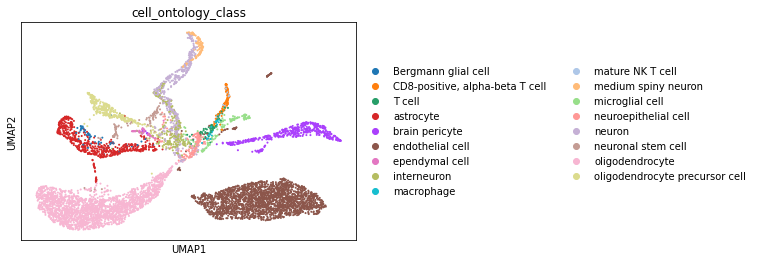

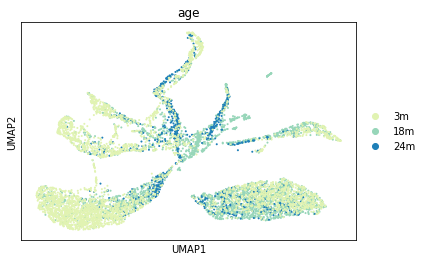

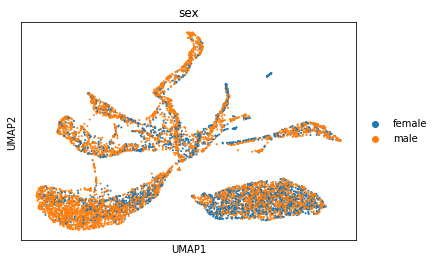

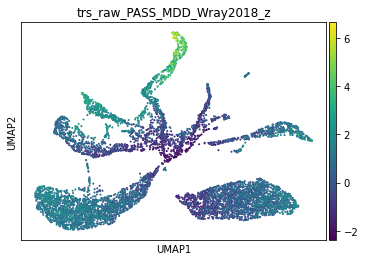

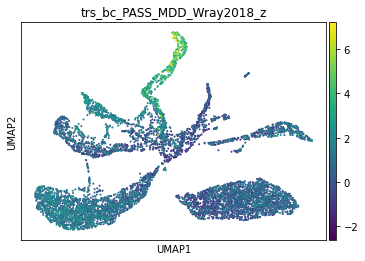

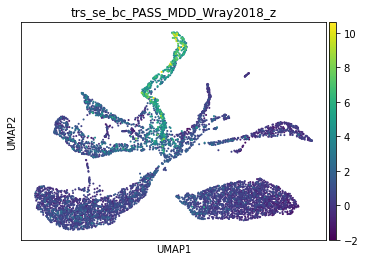

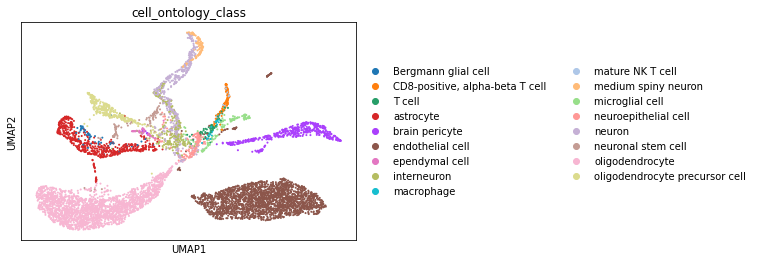

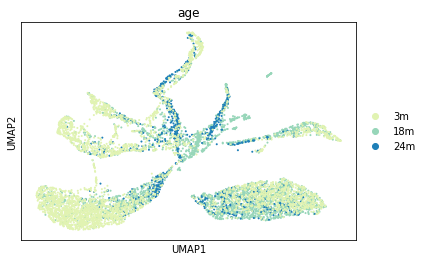

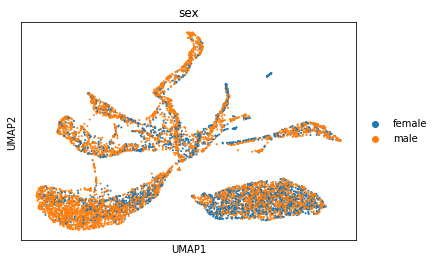

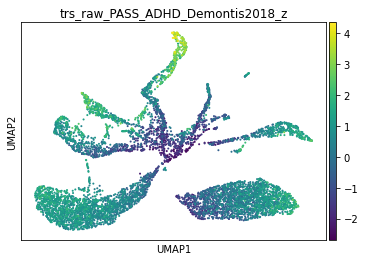

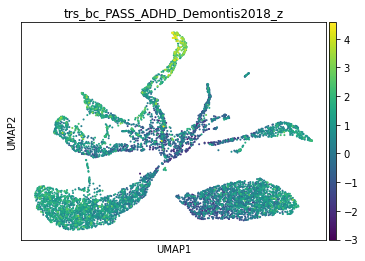

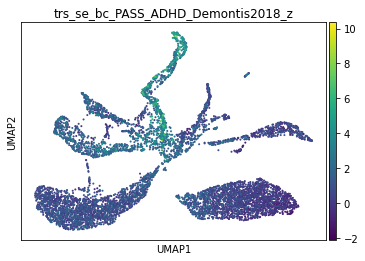

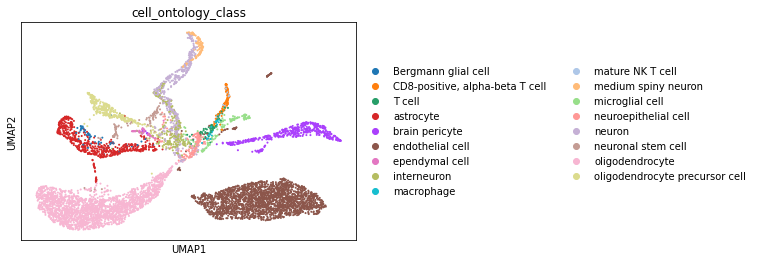

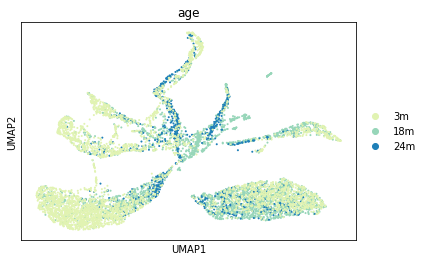

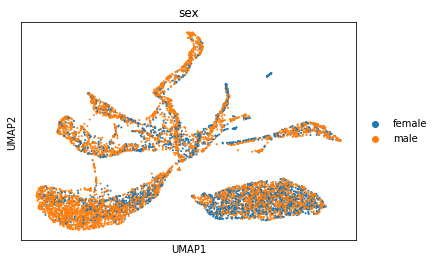

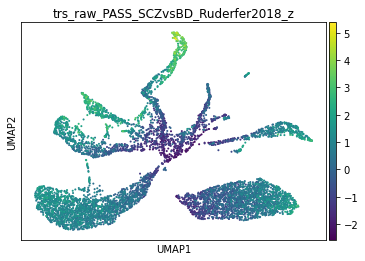

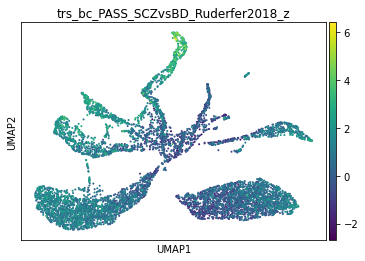

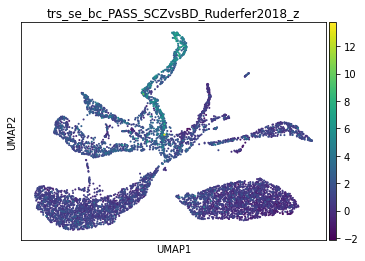

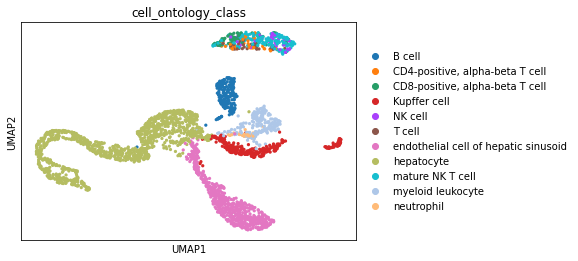

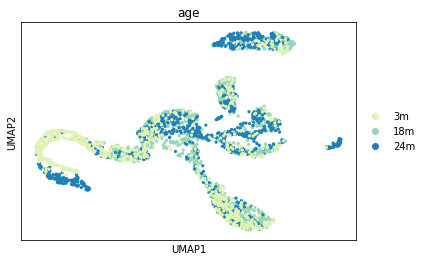

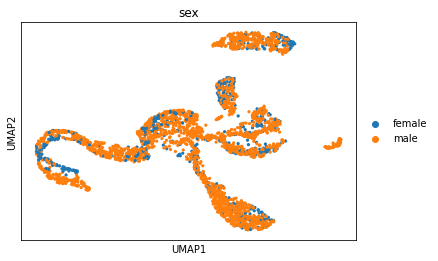

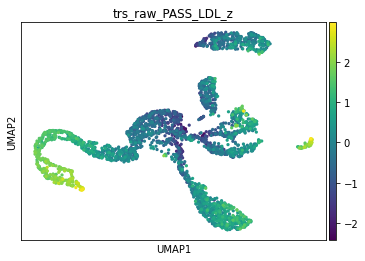

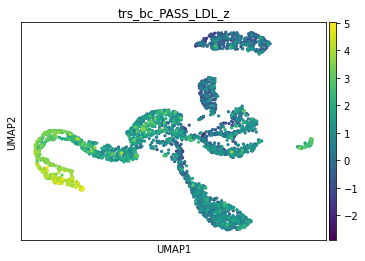

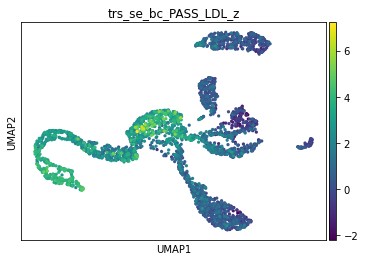

In [12]:
# Look at UMAP plot for tissue-trait pairs
plot_list = [['Brain_Non-Myeloid', 'PASS_MDD_Wray2018'],
             ['Brain_Non-Myeloid', 'PASS_ADHD_Demontis2018'],
             ['Brain_Non-Myeloid', 'PASS_SCZvsBD_Ruderfer2018'],
             ['Liver', 'PASS_LDL']]

for term in plot_list:
    tissue,trait = term
    
    sc.pl.umap(dic_data_facs[tissue], color='cell_ontology_class', save=None)
    sc.pl.umap(dic_data_facs[tissue], color='age', save=None)
    sc.pl.umap(dic_data_facs[tissue], color='sex', save=None)
    
    for trs_type in ['raw', 'bc', 'se_bc']:
        dic_data_facs[tissue].obs[f'trs_{trs_type}_{trait}_z'] = data_facs_ct.obs.loc[dic_data_facs[tissue].obs.index,
                                                                     f'trs_{trs_type}_{trait}_z']
    
        sc.pl.umap(dic_data_facs[tissue], color=[f'trs_{trs_type}_{trait}_z'])